In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import datetime
import tensorflow as tf

### Importing data

In [4]:
df = pd.read_csv('data/clean_data.csv')
# df = pd.read_csv('data/clean_data1990.csv') # For data further back
df = (df
        .drop('Unnamed: 0',axis=1)
        .assign(obs=lambda x: list(x.index))
        .set_index(pd.to_datetime(df.Date)))
        
# df = df[df.index.year > 2010]

### Cleaning & Feature Engineering

$2s10s = yield_{10y} - yield_{2y}$

In [5]:
features = pd.read_excel('data/Features.xlsx')
features = features.drop('HYcdx5y',axis=1)
features = features.dropna().iloc[::-1]

features.index = pd.to_datetime(features.Date)
dates = features.index.strftime('%Y-%m-01')
features['Date'] = dates
features.index = pd.to_datetime(dates)
features.rename({'Date':'feature_date'},axis=1,inplace=True)

features['2s10s'] = features.yield10y-features.yield2y
features['5s30s'] = features.yield30y-features.yield5y
features['VIXchg'] =  features.VIX.pct_change()
features = features.shift(1).dropna().sort_index()
# features.head()

In [6]:
monthly_df = pd.DataFrame(df.groupby(df.index.strftime('%y/%m')).default.sum())
monthly_df['Date'] = monthly_df.index
monthly_df.index = monthly_df.Date.apply(datetime.datetime.strptime,args=('%y/%m',))
monthly_df['obs'] = range(1,monthly_df.shape[0]+1)
monthly_df['month'] = monthly_df.index.month

In [7]:
monthly_df['lag1'] = monthly_df.default.shift(1)
# monthly_df['lag12'] = monthly_df.default.shift(12)
# monthly_df['ma12'] = monthly_df.default.rolling(12).mean()

model_df = pd.merge(monthly_df.dropna(),features,left_index=True,right_index=True)
del model_df['Date']
# model_df.head()

### Visualization / Investigation

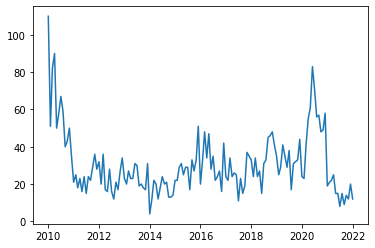

In [8]:
plt.plot(monthly_df.index,monthly_df.default)

In [9]:
tsa.pacf(monthly_df.default,12)

array([ 1.        ,  0.64345408,  0.33889936,  0.1810516 , -0.20897457,
       -0.03561384,  0.00276801, -0.03434498, -0.1250954 , -0.0877962 ,
        0.00293485,  0.00906027,  0.06754004])

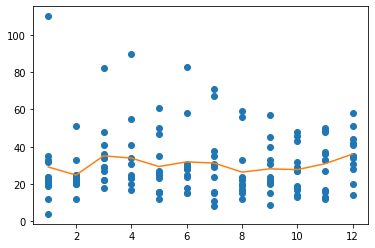

In [10]:
seasonal = monthly_df.groupby('month').default.mean()
plt.plot(monthly_df.month,monthly_df.default,'o')
plt.plot(range(1,13),seasonal.values)

In [11]:
model_df.corr().iloc[0].sort_values(ascending=False)
# plt.plot(model_df.VIX,model_df.default,'o')

default           1.000000
lag1              0.700492
VIX               0.407887
bbb10yspr         0.347739
initialjobless    0.341868
U3rate            0.332132
DXYindex          0.163628
isRec             0.141195
yield2y           0.100773
month             0.090811
fedfunds          0.076762
yield5y           0.030794
VIXchg            0.001205
yield10y         -0.012704
obs              -0.023051
yield30y         -0.026853
5s30s            -0.059963
IGcdx5y          -0.096495
2s10s            -0.106517
Name: default, dtype: float64

### Linear Model

- Level of outstanding debt in the economy
- Average leverage ratios
- 

In [31]:
# Train/Test splitting
n = 18
length = model_df.default.count()

train_df = model_df.head(length-n)
test_df = model_df.tail(n)

In [32]:
model_df.columns

Index(['default', 'obs', 'month', 'lag1', 'feature_date', 'fedfunds',
       'yield2y', 'yield10y', 'bbb10yspr', 'IGcdx5y', 'U3rate', 'yield5y',
       'yield30y', 'DXYindex', 'VIX', 'initialjobless', 'isRec', '2s10s',
       '5s30s', 'VIXchg'],
      dtype='object')

In [33]:
cols = ['lag1','bbb10yspr','2s10s','U3rate','isRec']

In [34]:

# model = sm.OLS(model_df.default,model_df[cols]).fit()
model = sm.OLS(train_df.default,train_df[cols]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                default   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              241.3
Date:                Mon, 14 Mar 2022   Prob (F-statistic):                    3.70e-61
Time:                        17:08:58   Log-Likelihood:                         -471.39
No. Observations:                 126   AIC:                                      952.8
Df Residuals:                     121   BIC:                                      967.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lag1           0.5309      0.064      8.342      0.000       0.405       0.657
bbb10yspr      5.6761      2.147      2.644      0.009       1.426       9.927
2s10s         -5.3329      1.613     -3.306      0.001      -8.526      -2.140
U3rate         1.7332      0.681      2.544      0.012       0.384       3.082
isRec         13.9388      7.728      1.804      0.074      -1.360      29.238
==============================================================================
Omnibus:                       14.071   Durbin-Watson:                   2.230
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.981
Skew:                           0.609   Prob(JB):                     7.56e-05
Kurtosis:                       4.460   Cond. No.                         294.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

7.718966077155534

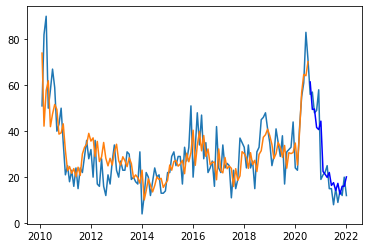

In [35]:
plt.plot(model_df.index,model_df.default)

# plt.plot(model_df.index,model.predict(model_df[cols]))
plt.plot(train_df.index,model.predict(train_df[cols]))
plt.plot(test_df.index,model.predict(test_df[cols]),color='blue')

# plt.plot(model_df.index, model.resid.abs())
model.resid.abs().mean() # MAE


### Best Subset Selection

In [17]:
import itertools
import time

In [18]:
feats = ['bbb10yspr','2s10s','U3rate','isRec','fedfunds','obs','VIX','DXYindex','5s30s','yield2y','yield10y','initialjobless']

In [63]:
class BESS:

    models_best = pd.DataFrame(columns=["RSS", "model"])

    def __init__(self,X,y,features: list,nvmax = 2,test_y=None,test_X=None):
        self.X = X
        self.y = y
        self.features = features
        self.nvmax = nvmax
        self.test_y = test_y
        self.test_X = test_X


    def processSubset(self,feature_set,):
        feature_set = list(feature_set)
        X = self.X[feature_set]
        model = sm.OLS(self.y,X)
        regr = model.fit()
        
        if type(self.test_y) != type(None) and type(self.test_X) != type(None):
            test_X = self.test_X[feature_set]
            RSS = ((regr.predict(test_X) - self.test_y) ** 2).sum()
        else:
            RSS = ((regr.predict(X) - self.y) ** 2).sum()
            
        return {"model":regr, "RSS":RSS}

    def getBest(self,k):
        tic = time.time()
        results = []
        
        for combo in itertools.combinations(self.X[self.features].columns, k):
            results.append(self.processSubset(combo))
        
        models = pd.DataFrame(results)
        best_model = models.loc[models.RSS.argmin()]
        
        toc = time.time()
        print("Analyzed", models.shape[0], "models with", k, "predictors in", round(toc-tic,3), "seconds")
        
        return best_model

    def search(self):
        self.models_best = pd.DataFrame(columns=["RSS", "model"])
        tic = time.time()

        for i in range(1,self.nvmax+1):
            self.models_best.loc[i] = self.getBest(i)

        toc = time.time()
        # print("Total elapsed time:", round(toc-tic,3), "seconds")

        self.models_best["R_sq"] = self.models_best.model.apply(lambda x: x.rsquared)
        self.models_best["adj_R_sq"] = self.models_best.model.apply(lambda x: x.rsquared_adj)

        return self.models_best

In [64]:
best = BESS(train_df,train_df.default,features=feats,nvmax=7)
models = best.search()
models

Analyzed 12 models with 1 predictors in 0.039 seconds
Analyzed 66 models with 2 predictors in 0.119 seconds
Analyzed 220 models with 3 predictors in 0.307 seconds
Analyzed 495 models with 4 predictors in 1.912 seconds
Analyzed 792 models with 5 predictors in 0.973 seconds
Analyzed 924 models with 6 predictors in 1.128 seconds
Analyzed 792 models with 7 predictors in 1.002 seconds


,RSS,model,R_sq,adj_R_sq
1,24794.771336,<statsmodels.regression.linear_model.Regressio...,0.827541,0.826161
2,21047.282744,<statsmodels.regression.linear_model.Regressio...,0.853607,0.851245
3,17034.990007,<statsmodels.regression.linear_model.Regressio...,0.881514,0.878624
4,16528.030059,<statsmodels.regression.linear_model.Regressio...,0.885040,0.881271
5,15933.018167,<statsmodels.regression.linear_model.Regressio...,0.889179,0.884599
6,15673.907268,<statsmodels.regression.linear_model.Regressio...,0.890981,0.885530
7,15479.396257,<statsmodels.regression.linear_model.Regressio...,0.892334,0.886000


In [65]:
best_model = models.model.iloc[models.adj_R_sq.argmax()]
best_feats = list(best_model.params.index)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                default   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              140.9
Date:                Mon, 14 Mar 2022   Prob (F-statistic):                    1.71e-54
Time:                        18:54:39   Log-Likelihood:                         -481.88
No. Observations:                 126   AIC:                                      977.8
Df Residuals:                     119   BIC:                                      997.6
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bbb10yspr      5.5915      4.573      1.223      0.224      -3.463      14.646
U3rate         5.3702      0.787      6.825      0.000       3.812       6.928
isRec         25.4512      9.342      2.724      0.007       6.953      43.950
obs           -0.1739      0.086     -2.027      0.045      -0.344      -0.004
DXYindex       0.2494      0.152      1.636      0.105      -0.052       0.551
5s30s        -18.8902      3.783     -4.994      0.000     -26.381     -11.400
yield2y        3.9759      2.212      1.797      0.075      -0.405       8.357
==============================================================================
Omnibus:                       19.921   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.551
Skew:                           0.853   Prob(JB):                     1.72e-06
Kurtosis:                       4.464   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

9.051683432578367

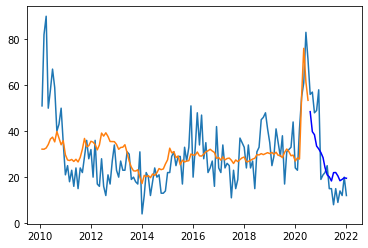

In [62]:
plt.plot(model_df.index,model_df.default)

# plt.plot(model_df.index,model.predict(model_df[cols]))
plt.plot(train_df.index,best_model.predict(train_df[best_feats]))
plt.plot(test_df.index,best_model.predict(test_df[best_feats]),color='blue')

# plt.plot(model_df.index, model.resid.abs())
best_model.resid.abs().mean() # MAE

### Principle Component Regression

In [36]:
from statsmodels.multivariate.pca import PCA

pca_df = model_df.drop(['default','feature_date'],axis=1)
pc = PCA(pca_df,7)
factors = sm.add_constant(pc.factors)
pc_model = sm.OLS(model_df.default,\
                  factors).fit()
pc_model.summary()

/Users/landon/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     29.96
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           1.00e-24
Time:                        17:11:14   Log-Likelihood:                -529.51
No. Observations:                 144   AIC:                             1075.
Df Residuals:                     136   BIC:                             1099.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8542      0.820     36.395      0.000      28.232      31.476
comp_0        -6.5997      9.843     -0.670      0.504     -26.066      12.866
comp_1        25.8000      9.843      2.621      0.010       6.334      45.266
comp_2       100.0118      9.843     10.160      0.000      80.546     119.478
comp_3       -78.0624      9.843     -7.930      0.000     -97.528     -58.597
comp_4        -0.9739      9.843     -0.099      0.921     -20.440      18.492
comp_5       -59.1391      9.843     -6.008      0.000     -78.605     -39.673
comp_6        -4.1092      9.843     -0.417      0.677     -23.575      15.357
==============================================================================
Omnibus:                       23.483   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.719
Skew:                           0.824   Prob(JB):                     1.06e-08
Kurtosis:                       4.845   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

7.253945527323294

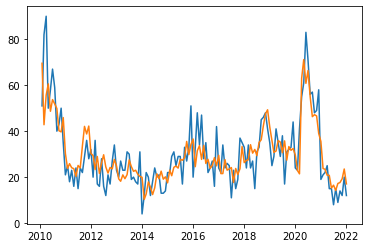

In [37]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,pc_model.predict(factors))
pc_model.resid.abs().mean() # MAE

### KNN Model

In [76]:
reg = KNeighborsRegressor(5)
neighbor = reg.fit(model_df[cols],model_df.default)

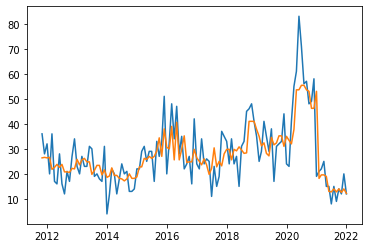

In [77]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,neighbor.predict(model_df[cols]))


### Tensorflow Models

#### Data Cleaning

In [1119]:
# train_df = model_df.sample(frac=0.8)
# test_df = model_df.drop(train_df.index)

factors['default'] = model_df.default
train_df = factors.sample(frac=0.8)
test_df = factors.drop(train_df.index)

In [1120]:
train_target = train_df.default.values
# train_feature_tensor = tf.convert_to_tensor(train_df[cols])
train_feature_tensor = tf.convert_to_tensor(train_df.drop('default',axis=1))


test_target = test_df.default.values
# test_feature_tensor = tf.convert_to_tensor(test_df[cols])
test_feature_tensor = tf.convert_to_tensor(test_df.drop('default',axis=1))

In [1121]:
normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(train_df[cols])
normalizer.adapt(train_df.drop('default',axis=1))


#### Model Building

In [1122]:
net = tf.keras.models.Sequential([
    normalizer,
    # tf.keras.layers.Flatten(input_shape=(len(cols),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)])

net.compile(optimizer='adam',
            loss=tf.losses.MeanSquaredError())
# metrics=['loss']

In [1196]:
net.fit(train_feature_tensor, train_target, epochs=128, batch_size=5)

Epoch 1/128
20/20 [==============================] - 0s 5ms/step - loss: 33.1278
Epoch 2/128
20/20 [==============================] - 0s 3ms/step - loss: 40.6248
Epoch 3/128
20/20 [==============================] - 0s 4ms/step - loss: 34.1689
Epoch 4/128
20/20 [==============================] - 0s 4ms/step - loss: 35.5792
Epoch 5/128
20/20 [==============================] - 0s 3ms/step - loss: 44.6354
Epoch 6/128
20/20 [==============================] - 0s 2ms/step - loss: 27.1695
Epoch 7/128
20/20 [==============================] - 0s 3ms/step - loss: 40.5468
Epoch 8/128
20/20 [==============================] - 0s 3ms/step - loss: 56.1707
Epoch 9/128
20/20 [==============================] - 0s 3ms/step - loss: 31.9443
Epoch 10/128
20/20 [==============================] - 0s 2ms/step - loss: 38.0309
Epoch 11/128
20/20 [==============================] - 0s 2ms/step - loss: 35.8398
Epoch 12/128
20/20 [==============================] - 0s 2ms/step - loss: 35.8662
Epoch 13/128
20/20 [=====

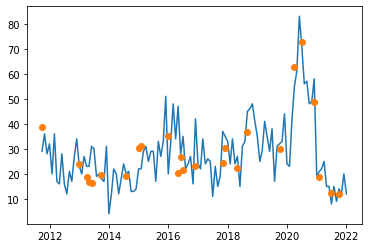

In [1197]:
plt.plot(model_df.index,model_df.default)
plt.plot(test_df.index,net.predict(test_feature_tensor),'o')